In [ ]:
!pip install torchmetrics -q
!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 7.1 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import random
import numpy as np
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummaryX import summary
from tqdm.auto import tqdm
import os
import gc
from matplotlib import pyplot as plt
import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torchmetrics.regression import MeanAbsolutePercentageError

cpu


# **Feature Enigneering**

## **User data**

In [ ]:
path = '/content/drive/MyDrive/movie_rec/'
df_user = pd.read_csv(path+"users.csv")
print(df_user.isnull().sum())
df_user
df_u = pd.get_dummies(df_user)
df_u

user_id       0
age           0
occupation    0
gender        0
dtype: int64


,user_id,age,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,...,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer,gender_F,gender_M
0,1,34,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,5,26,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,7,31,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,9,24,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,10,38,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125621,228869,38,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
125622,228870,34,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
125623,228871,18,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
125624,228874,30,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


<Axes: xlabel='count', ylabel='gender'>

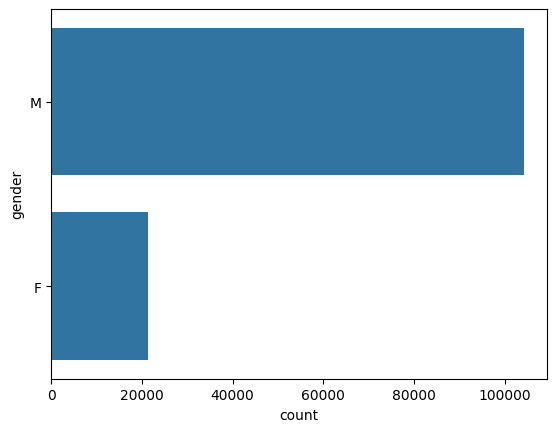

In [ ]:
sns.countplot(df_user['gender'])

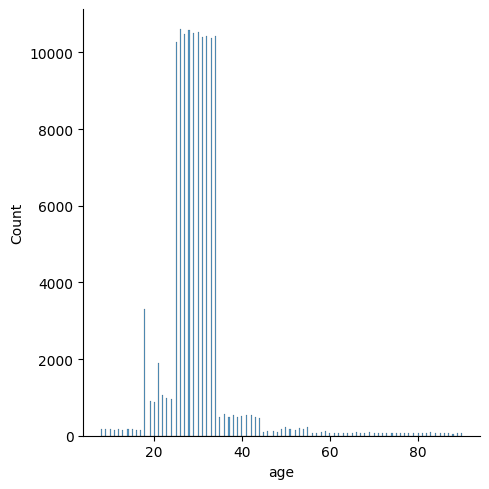

In [ ]:
sns.displot(df_user['age'])

<Axes: xlabel='count', ylabel='occupation'>

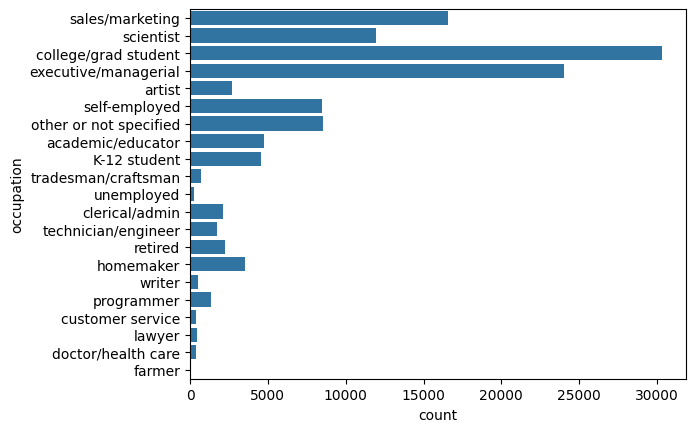

In [ ]:
sns.countplot(df_user['occupation'])

## **Movie Data**

In [ ]:
df_movie = pd.read_csv(path+"movies.csv")
df_movie.tail()

,id,tmdb_id,imdb_id,title,original_title,adult,belongs_to_collection,budget,genres,homepage,...,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count
25673,touching+the+void+2003,11194,tt0379557,Touching the Void,Touching the Void,False,{},0,"[{'id': 99, 'name': 'Documentary'}, {'id': 28,...",NaN,...,/ozExRDtiwDqyIcRfZ7Zi14EPbiX.jpg,"[{'name': 'Darlow Smithson Productions', 'id':...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2003-09-05,13885802,106,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.6,139
25674,winners++sinners+1983,25539,tt0086605,Winners & Sinners,奇謀妙計五福星,False,"{'id': 300431, 'name': 'Lucky Stars Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,...,/mZIF6SrqNv51tiXHFk14pMpvkf8.jpg,"[{'name': 'Golden Harvest Company', 'id': 2521}]","[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",1983-01-01,0,108,"[{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}]",Released,6.3,33
25675,salt+of+the+earth+1954,23620,tt0047443,Salt of the Earth,Salt of the Earth,False,{},0,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",NaN,...,/frucPta5KnSkRyRM7yGWoXPtdj2.jpg,"[{'name': 'Intl Union of Mine, Mill & Smelter ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1954-03-14,0,94,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Released,7.3,17
25676,the+great+sacrifice+1944,97088,tt0037154,The Great Sacrifice,Opfergang,False,{},0,"[{'id': 18, 'name': 'Drama'}]",NaN,...,/xIhTlM1qJ8DguQqUQd4TIIUST90.jpg,"[{'name': 'Universum Film (UFA)', 'id': 12372}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1944-12-08,0,98,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,6.0,3
25677,the+man+from+monterey+1933,80592,tt0024293,The Man from Monterey,The Man from Monterey,False,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 37, 'nam...",NaN,...,/55cmzi8ypssFFG8K91HXhj3b5vW.jpg,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1933-07-15,0,57,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,5.3,4


In [ ]:
def movie_feature(dff): #turn list of dictionary to list of strings with only the name
    import ast
    df = dff.copy()
    df['genres'] = dff['genres'].apply( lambda x: [i['name'] for i in ast.literal_eval(x)] )
    df['belongs_to_collection'] = dff['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)['name'] if ast.literal_eval(x) != {} else None)
    df['production_companies'] = dff['production_companies'].apply(lambda x:[i['name'] for i in ast.literal_eval(x)])
    df['production_countries'] = dff['production_countries'].apply(lambda x:[i['name'] for i in ast.literal_eval(x)])
    df['spoken_languages'] =     dff['spoken_languages'].apply(lambda x:[i['name'] if i['name']!='' else 'English' for i in ast.literal_eval(x)])
    df['original_language'] = df['original_language'].astype(str)
    return df[df.columns.difference(['homepage','poster_path','display.max_columns', 'belongs_to_collection',  'original_title','production_companies' ])]
df_movie_fea = movie_feature(df_movie)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
  display(df_movie_fea)


,adult,budget,genres,id,imdb_id,original_language,overview,popularity,production_countries,release_date,revenue,runtime,spoken_languages,status,title,tmdb_id,vote_average,vote_count
0,False,0,"[Comedy, Crime, Mystery]",nobody+else+but+you+2011,tt1736636,en,"The ambiguous suicide of a local beauty, weath...",3.352027,[France],2011-01-12,0,102,[Français],Released,Nobody Else But You,53776,5.9,28
1,False,50000000,"[Science Fiction, Action, Horror]",alien+1992,tt0103644,en,After escaping with Newt and Hicks from the al...,17.126768,"[United Kingdom, United States of America]",1992-05-22,159773545,114,[English],Released,Alien³,8077,6.2,1664
2,False,7000000,"[Adventure, Comedy, Fantasy, Horror]",warlock+1989,tt0098622,en,A warlock flees from the 17th to the 20th cent...,11.906872,[United States of America],1989-06-01,0,103,[English],Released,Warlock,11342,5.8,98
3,False,0,[Drama],k-11+2013,tt1329177,en,"Raymond Saxx Jr., a powerful record producer, ...",1.686305,[United States of America],2013-03-15,0,88,"[English, Español]",Released,K-11,170178,4.3,11
4,False,0,"[Documentary, Foreign]",knuckle+2011,tt1606259,en,An epic 12-year journey into the brutal and se...,1.213981,[],2011-12-09,0,97,[],Released,Knuckle,71771,5.1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25673,False,0,"[Documentary, Action, Adventure]",touching+the+void+2003,tt0379557,en,A documentary based on the book of the same na...,7.594022,[United Kingdom],2003-09-05,13885802,106,[English],Released,Touching the Void,11194,7.6,139
25674,False,0,"[Action, Adventure, Comedy, Crime]",winners++sinners+1983,tt0086605,cn,Five friends are released from prison and do t...,2.272623,[Hong Kong],1983-01-01,0,108,[广州话 / 廣州話],Released,Winners & Sinners,25539,6.3,33
25675,False,0,"[History, Drama]",salt+of+the+earth+1954,tt0047443,en,The issues the miners strike for include equit...,0.979701,[United States of America],1954-03-14,0,94,"[Español, English]",Released,Salt of the Earth,23620,7.3,17
25676,False,0,[Drama],the+great+sacrifice+1944,tt0037154,de,A young woman from Sweden (Kristina Söderbaum)...,0.128118,[Germany],1944-12-08,0,98,[Deutsch],Released,The Great Sacrifice,97088,6.0,3


In [ ]:
df_movie_fea.isnull().sum()

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                  10
original_language         0
overview                261
popularity                0
production_countries      0
release_date             25
revenue                   0
runtime                   0
spoken_languages          0
status                   37
title                     0
tmdb_id                   0
vote_average              0
vote_count                0
dtype: int64

In [ ]:
def movie_data_fillna(df_movie_fea):
  df_movie_fea['status'] = df_movie_fea['status'].fillna('Released')
  pd.to_datetime(df_movie_fea['release_date']).mean()
  df_movie_fea['release_date'] = df_movie_fea['release_date'].fillna('1989-11-01')
  df_movie_fea['overview'] = df_movie_fea['overview'].fillna('None')
  df_movie_fea['imdb_id'] = df_movie_fea['imdb_id'].fillna('None')
  # df_movie_fea['belongs_to_collection'] = df_movie_fea['belongs_to_collection'].fillna('None')
  df_movie_fea[pd.isna(df_movie_fea['original_language'])]['original_language']='en'
  df_movie_fea['original_language'] = df_movie_fea['original_language'].apply(lambda x:x if type(x)==list else [x])
  df_movie_fea.isnull().sum()
  return df_movie_fea
df_movie_fea = movie_data_fillna(df_movie_fea)
print(df_movie_fea.isnull().sum())

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
overview                0
popularity              0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
tmdb_id                 0
vote_average            0
vote_count              0
dtype: int64


In [ ]:
def calc_zero_percentage(df):
  df = df.select_dtypes(include='number')
  dic = {}
  for col in df.columns:
      dic[col]= len(df[df[col]==0])/len(df)*100

  return dic
calc_zero_percentage(df_movie_fea)

{'budget': 73.77911052262637,
 'popularity': 0.08957083885037775,
 'revenue': 76.04564218397071,
 'runtime': 1.7758392398161853,
 'tmdb_id': 0.0,
 'vote_average': 4.081314744138951,
 'vote_count': 3.929433756523094}

In [ ]:
genre_list = df_movie_fea['genres'].values
genre_list = np.unique([j for i in genre_list for j in i])
genre_list.shape[0], genre_list

(20,
 array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
        'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
        'TV Movie', 'Thriller', 'War', 'Western'], dtype='<U15'))

In [ ]:
production_countries_list = df_movie_fea['production_countries'].values
production_countries_list = np.unique([j for i in production_countries_list for j in i])
production_countries_list.shape[0], production_countries_list[:5]

(147,
 array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina'],
       dtype='<U36'))

In [ ]:
original_language_list = df_movie_fea['original_language'].values
original_language_list = np.unique([j+'_lan' for i in original_language_list for j in i])
original_language_list.shape[0], original_language_list

(83,
 array(['ab_lan', 'af_lan', 'am_lan', 'ar_lan', 'ay_lan', 'bg_lan',
        'bm_lan', 'bn_lan', 'bo_lan', 'bs_lan', 'ca_lan', 'cn_lan',
        'cs_lan', 'cy_lan', 'da_lan', 'de_lan', 'el_lan', 'en_lan',
        'eo_lan', 'es_lan', 'et_lan', 'eu_lan', 'fa_lan', 'fi_lan',
        'fr_lan', 'fy_lan', 'gl_lan', 'he_lan', 'hi_lan', 'hr_lan',
        'hu_lan', 'id_lan', 'is_lan', 'it_lan', 'ja_lan', 'jv_lan',
        'ka_lan', 'kk_lan', 'kn_lan', 'ko_lan', 'ku_lan', 'ky_lan',
        'la_lan', 'lo_lan', 'lt_lan', 'lv_lan', 'mk_lan', 'ml_lan',
        'mn_lan', 'mr_lan', 'ms_lan', 'nan_lan', 'nb_lan', 'ne_lan',
        'nl_lan', 'no_lan', 'pa_lan', 'pl_lan', 'ps_lan', 'pt_lan',
        'qu_lan', 'ro_lan', 'ru_lan', 'rw_lan', 'sh_lan', 'sk_lan',
        'sl_lan', 'sq_lan', 'sr_lan', 'sv_lan', 'ta_lan', 'te_lan',
        'tg_lan', 'th_lan', 'tl_lan', 'tr_lan', 'uk_lan', 'ur_lan',
        'vi_lan', 'wo_lan', 'xx_lan', 'zh_lan', 'zu_lan'], dtype='<U7'))

In [ ]:
spoken_languages_list = df_movie_fea['spoken_languages'].values
spoken_languages_list = np.unique([j+'_lang' for i in spoken_languages_list for j in i])
spoken_languages_list.shape[0], spoken_languages_list

(72,
 array(['??????_lang', '?????_lang', 'Afrikaans_lang', 'Azərbaycan_lang',
        'Bahasa indonesia_lang', 'Bahasa melayu_lang', 'Bamanankan_lang',
        'Bokmål_lang', 'Bosanski_lang', 'Català_lang', 'Cymraeg_lang',
        'Dansk_lang', 'Deutsch_lang', 'Eesti_lang', 'English_lang',
        'Español_lang', 'Esperanto_lang', 'Français_lang', 'Fulfulde_lang',
        'Gaeilge_lang', 'Galego_lang', 'Hrvatski_lang', 'Italiano_lang',
        'Kinyarwanda_lang', 'Kiswahili_lang', 'Latin_lang',
        'Latviešu_lang', 'Lietuviakai_lang', 'Magyar_lang', 'Malti_lang',
        'Nederlands_lang', 'No Language_lang', 'Norsk_lang', 'Polski_lang',
        'Português_lang', 'Pусский_lang', 'Română_lang', 'Slovenčina_lang',
        'Slovenščina_lang', 'Somali_lang', 'Srpski_lang',
        'Tiếng Việt_lang', 'Türkçe_lang', 'Wolof_lang', 'euskera_lang',
        'isiZulu_lang', 'shqip_lang', 'suomi_lang', 'svenska_lang',
        'Íslenska_lang', 'Český_lang', 'ελληνικά_lang', 'Український_lang',

In [ ]:
def expand_list_to_rows(df, column_name): #expand columns with list of multiple values to multiple rows
    """
    Expand each list in the specified column of the dataframe into separate rows, while retaining the original index.
    """
    rows = []
    counter =0
    for i, row in df.iterrows():
        lists = row[column_name]
        if type(lists)==list:
          if lists != 'None' and len(lists)!=0:
              for item in lists:
                  new_row = row.to_dict()
                  new_row[column_name] = item
                  new_row['original_index'] = i  # Add original index to each row
                  rows.append(new_row)
          else:
              new_row = row.to_dict()
              new_row[column_name] = 'None'
              new_row['original_index'] = i
              rows.append(new_row)
    expanded_df = pd.DataFrame(rows)
    return expanded_df

def efficient_movie_feature_encoding(df, list_columns):
    """
    Efficiently one-hot encode columns that contain lists as values.
    """
    # First, handle normal features that don't need expansion
    useless_feature = ['imdb_id', 'overview', 'title', 'tmdb_id', 'budget', 'revenue']
    df = df[df.columns.difference(useless_feature)]
    normal_features_df = df[df.columns.difference(list_columns + useless_feature)]

    # Then, for each list column, expand and one-hot encode it
    encoded_dfs = [normal_features_df]
    for column in tqdm(list_columns):
        expanded_df = expand_list_to_rows(df, column)
        encoded_df = pd.get_dummies(expanded_df, columns=[column], prefix=column)
        encoded_df = encoded_df[encoded_df.columns.difference(list_columns)]

        reduced_df = encoded_df.groupby('original_index').last()
        # print(reduced_df.isnull().sum().last(), len(reduced_df))
        # Aggregate back to original DataFrame index
        encoded_dfs.append(reduced_df)

    final_df = pd.concat(encoded_dfs, axis=1)

    # Handle any duplicated columns due to concatenation, if necessary
    final_df = final_df.loc[:,~final_df.columns.duplicated()]

    return final_df

list_columns = ['genres','original_language']
df_m = efficient_movie_feature_encoding(df_movie_fea, list_columns)
print("#Null:" ,df_m.isnull().sum().max())
df_m

  0%|          | 0/2 [00:00<?, ?it/s]

#Null: 0


,adult,id,popularity,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,...,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,False,nobody+else+but+you+2011,3.352027,[France],2011-01-12,102,[Français],Released,5.9,28,...,0,0,0,0,0,0,0,0,0,0
1,False,alien+1992,17.126768,"[United Kingdom, United States of America]",1992-05-22,114,[English],Released,6.2,1664,...,0,0,0,0,0,0,0,0,0,0
2,False,warlock+1989,11.906872,[United States of America],1989-06-01,103,[English],Released,5.8,98,...,0,0,0,0,0,0,0,0,0,0
3,False,k-11+2013,1.686305,[United States of America],2013-03-15,88,"[English, Español]",Released,4.3,11,...,0,0,0,0,0,0,0,0,0,0
4,False,knuckle+2011,1.213981,[],2011-12-09,97,[],Released,5.1,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25673,False,touching+the+void+2003,7.594022,[United Kingdom],2003-09-05,106,[English],Released,7.6,139,...,0,0,0,0,0,0,0,0,0,0
25674,False,winners++sinners+1983,2.272623,[Hong Kong],1983-01-01,108,[广州话 / 廣州話],Released,6.3,33,...,0,0,0,0,0,0,0,0,0,0
25675,False,salt+of+the+earth+1954,0.979701,[United States of America],1954-03-14,94,"[Español, English]",Released,7.3,17,...,0,0,0,0,0,0,0,0,0,0
25676,False,the+great+sacrifice+1944,0.128118,[Germany],1944-12-08,98,[Deutsch],Released,6.0,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_m = df_m.drop(columns=['spoken_languages', 'production_countries'])
df_m['release_date'] = pd.to_datetime(df_m['release_date']).dt.year
df_m['adult'] = df_m['adult'].astype(int)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
  display(df_m)

,adult,id,popularity,release_date,runtime,status,vote_average,vote_count,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_None,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_ab,original_language_af,original_language_am,original_language_ar,original_language_ay,original_language_bg,original_language_bm,original_language_bn,original_language_bo,original_language_bs,original_language_ca,original_language_cn,original_language_cs,original_language_cy,original_language_da,original_language_de,original_language_el,original_language_en,original_language_eo,original_language_es,original_language_et,original_language_eu,original_language_fa,original_language_fi,original_language_fr,original_language_fy,original_language_gl,original_language_he,original_language_hi,original_language_hr,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_jv,original_language_ka,original_language_kk,original_language_kn,original_language_ko,original_language_ku,original_language_ky,original_language_la,original_language_lo,original_language_lt,original_language_lv,original_language_mk,original_language_ml,original_language_mn,original_language_mr,original_language_ms,original_language_nan,original_language_nb,original_language_ne,original_language_nl,original_language_no,original_language_pa,original_language_pl,original_language_ps,original_language_pt,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_sk,original_language_sl,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,0,nobody+else+but+you+2011,3.352027,2011,102,Released,5.9,28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,alien+1992,17.126768,1992,114,Released,6.2,1664,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,warlock+1989,11.906872,1989,103,Released,5.8,98,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,k-11+2013,1.686305,2013,88,Released,4.3,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,knuckle+2011,1.213981,2011,97,Released,5.1,11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25673,0,touching+the+void+2003,7.594022,2003,106,Released,7.6,139,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## **Interaction Data**

In [ ]:
df_rate = pd.read_csv(path+"rate_log.csv").rename(columns={'minutes':'rating'})
df_rate

,user_id,movie_id,time,rating
0,160766,the+tigger+movie+2000,2023-12-27T19:10:59,4
1,165531,ring+of+bright+water+1969,2023-12-28T00:36:59,3
2,209904,a+grand+day+out+1990,2023-12-28T00:52:32,4
3,99425,the+french+connection+1971,2023-12-28T22:20:30,4
4,180714,the+princess+bride+1987,2023-12-29T02:23:51,4
...,...,...,...,...
440526,62018,the+well-diggers+daughter+1940,2024-02-07T12:19:10,3
440527,157913,red+desert+1964,2024-02-07T12:19:15,4
440528,184538,mabel+at+the+wheel+1914,2024-02-07T12:19:15,3
440529,12902,frozen+2013,2024-02-07T12:19:17,5


In [ ]:
df_watch = pd.read_csv(path+"watch_log.csv").rename(columns={'start_time':'time'})
df_watch

,user_id,movie_id,time,minutes
0,99788,the+brothers+2001,2023-12-27T17:24:12,107
1,160766,the+tigger+movie+2000,2023-12-27T17:52:03,78
2,33394,as+good+as+it+gets+1997,2023-12-27T18:30:23,18
3,22133,waterworld+1995,2023-12-27T21:19:57,46
4,209904,a+grand+day+out+1990,2023-12-28T00:28:07,24
...,...,...,...,...
637106,73280,harry+potter+and+the+order+of+the+phoenix+2007,2024-02-07T12:19:12,0
637107,27255,spirited+away+2001,2024-02-07T12:19:13,0
637108,37592,dawn+of+the+planet+of+the+apes+2014,2024-02-07T12:19:14,0
637109,165664,the+mighty+macs+2009,2024-02-07T12:19:15,0


In [ ]:
df_rating = df_rate.merge(df_watch, how ='outer', on=['user_id','movie_id'], suffixes=('_r','_w'))
df_rating = df_rating[df_rating['minutes']!=0]

In [ ]:
df_rating.isnull().sum() #Null comes from user watch movie but did not rate, we give it a rating based on watching duration

user_id          0
movie_id         0
time_r      196495
rating      196495
time_w           0
minutes          0
dtype: int64

## **Turn watch to ratings**

In [ ]:
def calc_score(x):
    if x>100:
        return 5.0
    return x/20
df_rating = df_rating.drop(columns=['time_r'])
df_rating['rating'] = df_rating.apply(lambda x: calc_score(x['minutes']) if pd.isnull(x['rating']) else x['rating'], axis=1)
df_rating

,user_id,movie_id,rating,time_w,minutes
0,160766,the+tigger+movie+2000,4.00,2023-12-27T17:52:03,78
1,165531,ring+of+bright+water+1969,3.00,2023-12-28T00:30:09,6
2,209904,a+grand+day+out+1990,4.00,2023-12-28T00:28:07,24
3,99425,the+french+connection+1971,4.00,2023-12-28T20:34:12,105
4,180714,the+princess+bride+1987,4.00,2023-12-29T00:58:14,99
...,...,...,...,...,...
637055,139268,born+into+brothels+2004,0.05,2024-02-07T12:18:11,1
637058,152842,strawberries+in+the+supermarket+2003,0.05,2024-02-07T12:18:12,1
637059,142547,l.i.e.+2001,0.05,2024-02-07T12:18:13,1
637060,41,innocent+voices+2004,0.05,2024-02-07T12:18:16,1


## **Prepare data for training**

In [ ]:
df_rating['time']=pd.to_datetime(df_rating['time_w'])#.dt.date
df_rating = df_rating.drop(columns=['time_w','minutes'])
df_rating = df_rating.sort_values('time').reset_index(drop=True)
df_rating

,user_id,movie_id,rating,time
0,61670,the+sixth+sense+1999,5.00,2023-12-27 16:23:09
1,149304,snow+falling+on+cedars+1999,5.00,2023-12-27 16:23:13
2,137666,lord+of+war+2005,5.00,2023-12-27 16:23:36
3,101628,jurassic+park+1993,5.00,2023-12-27 16:23:39
4,139663,castle+in+the+sky+1986,5.00,2023-12-27 16:24:22
...,...,...,...,...
637021,35492,balto+1995,0.10,2024-02-07 12:18:16
637022,41,innocent+voices+2004,0.05,2024-02-07 12:18:16
637023,179000,ripleys+game+2002,0.05,2024-02-07 12:18:18
637024,21348,a+walk+in+the+sun+1945,0.05,2024-02-07 12:18:20


In [ ]:
data = df_rating.merge(df_u, 'left', on='user_id').fillna(0)
data = df_rating.merge(df_movie_fea, 'left', left_on='movie_id', right_on='id').drop(columns=['id'])
data = data.fillna(0)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
 display(data)

,user_id,movie_id,rating,time,adult,budget,genres,imdb_id,original_language,overview,popularity,production_countries,release_date,revenue,runtime,spoken_languages,status,title,tmdb_id,vote_average,vote_count
0,61670,the+sixth+sense+1999,5.00,2023-12-27 16:23:09,False,40000000.0,"[Mystery, Thriller, Drama]",tt0167404,[en],A psychological thriller about an eight year o...,18.449169,[United States of America],1999-08-06,672806292.0,107.0,"[Latin, Español, English]",Released,The Sixth Sense,745.0,7.7,3223.0
1,149304,snow+falling+on+cedars+1999,5.00,2023-12-27 16:23:13,False,0.0,"[Drama, Romance]",tt0120834,[en],A Japanese-American fisherman may have killed ...,2.813811,[United States of America],1999-12-22,0.0,127.0,"[Deutsch, 日本語, English]",Released,Snow Falling on Cedars,10219.0,6.3,32.0
2,137666,lord+of+war+2005,5.00,2023-12-27 16:23:36,False,42000000.0,"[Crime, Drama, Thriller]",tt0399295,[en],"Yuri Orlov is a globetrotting arms dealer and,...",8.745216,"[France, United States of America, Germany]",2005-09-16,24127895.0,122.0,"[العربية, Deutsch, English, Français, Pусский,...",Released,Lord of War,1830.0,7.0,1356.0
3,101628,jurassic+park+1993,5.00,2023-12-27 16:23:39,False,63000000.0,"[Adventure, Science Fiction]",tt0107290,[en],A wealthy entrepreneur secretly creates a them...,8.863776,[United States of America],1993-06-11,920100000.0,127.0,"[English, Español]",Released,Jurassic Park,329.0,7.6,4956.0
4,139663,castle+in+the+sky+1986,5.00,2023-12-27 16:24:22,False,0.0,"[Adventure, Fantasy, Animation, Action, Family...",tt0092067,[ja],The orphan Sheeta inherited a mysterious cryst...,11.061551,[Japan],1986-08-02,0.0,124.0,[日本語],Released,Castle in the Sky,10515.0,7.8,877.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637021,35492,balto+1995,0.10,2024-02-07 12:18:16,False,0.0,"[Family, Animation, Adventure]",tt0112453,[en],An outcast half-wolf risks his life to prevent...,12.140733,[United States of America],1995-12-22,11348324.0,78.0,[English],Released,Balto,21032.0,7.1,423.0
637022,41,innocent+voices+2004,0.05,2024-02-07 12:18:16,False,0.0,"[Drama, War]",tt0387914,[es],"A young boy, in an effort to have a normal chi...",7.559298,"[Mexico, Puerto Rico, United States of America]",2004-11-05,837000.0,120.0,[Español],Released,Innocent Voices,20941.0,7.6,33.0
637023,179000,ripleys+game+2002,0.05,2024-02-07 12:18:18,False,30000000.0,"[Crime, Thriller]",tt0265651,[en],"Tom Ripley - cool, urbane, wealthy, and murder...",7.743921,"[United Kingdom, United States of America, Italy]",2002-09-02,0.0,110.0,[English],Released,Ripley's Game,10955.0,6.6,70.0
637024,21348,a+walk+in+the+sun+1945,0.05,2024-02-07 12:18:20,False,0.0,"[War, Drama]",tt0038235,[en],"In the 1943 invasion of Italy, one American pl...",8.855910,[United States of America],1945-12-25,0.0,117.0,"[English, Italiano]",Released,A Walk in the Sun,43488.0,5.2,14.0


## **User_stats**

In [ ]:
user_rate_stats = data[['user_id','rating']].groupby('user_id')['rating'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index().fillna(0)
user_rate_stats
df_u = df_u.merge(user_rate_stats, 'left', 'user_id')

In [ ]:
user_rate_genre = data[['user_id', 'rating','genres']]
user_rate_genre = expand_list_to_rows(user_rate_genre, 'genres')
user_rate_genre

,user_id,rating,genres,original_index
0,61670,5.00,Mystery,0
1,61670,5.00,Thriller,0
2,61670,5.00,Drama,0
3,149304,5.00,Drama,1
4,149304,5.00,Romance,1
...,...,...,...,...
1706559,21348,0.05,War,637024
1706560,21348,0.05,Drama,637024
1706561,170889,0.05,Action,637025
1706562,170889,0.05,Thriller,637025


In [ ]:
user_rate_genre = user_rate_genre.groupby(['user_id', 'genres'])['rating'].mean().unstack(fill_value=0).reset_index()
user_rate_genre

genres,user_id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Mystery,None,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,4.950,0.000,0.0,0.00,4.95,0.0,4.000000,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,5,5.000,0.000,0.0,2.00,0.00,0.0,5.000000,0.00,5.00,...,0.0,0.0,5.0,0.0,5.000000,5.0,0.0,5.0,0.0,0.0
2,7,3.000,3.000,0.0,0.00,0.00,0.0,0.000000,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,3.0,0.0,0.0,0.0,0.0
3,9,0.000,0.000,0.0,0.00,0.00,3.0,0.000000,0.00,0.00,...,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,4.0,0.0,0.0
4,10,4.375,4.365,4.0,4.33,4.00,0.0,4.059091,4.55,4.55,...,5.0,0.0,4.0,0.0,4.333333,4.5,0.0,4.4,3.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125486,228869,0.000,0.000,3.0,3.00,0.00,0.0,0.000000,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
125487,228870,4.000,0.000,0.0,0.00,4.00,0.0,4.000000,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.0,0.0,0.0
125488,228871,0.000,0.000,0.0,0.00,0.00,0.0,4.000000,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
125489,228874,4.000,0.000,4.8,4.00,0.00,0.0,3.500000,4.80,0.00,...,3.0,0.0,3.0,0.0,4.000000,0.0,0.0,0.0,4.0,0.0


In [ ]:
df_u = df_u.merge(user_rate_genre, 'left', 'user_id')
df_u.head()

,user_id,age,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,...,Horror,Music,Mystery,None,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,34,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,5,26,0,0,0,0,0,0,0,0,...,0.0,0.0,5.0,0.0,5.000000,5.0,0.0,5.0,0.0,0.0
2,7,31,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,3.0,0.0,0.0,0.0,0.0
3,9,24,0,0,0,0,1,0,0,0,...,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,4.0,0.0,0.0
4,10,38,0,0,0,0,0,0,0,1,...,5.0,0.0,4.0,0.0,4.333333,4.5,0.0,4.4,3.8,0.0


In [ ]:
df_u.to_csv(path+'user_all_features.csv')

In [ ]:
data = df_rating.merge(df_u, 'left', on='user_id').fillna(0)
data = data.merge(df_m, 'left', left_on='movie_id', right_on='id').drop(columns=['id'])
data = data.fillna(0)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
 display(data)

,user_id,movie_id,rating,time,age,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,occupation_farmer,occupation_homemaker,occupation_lawyer,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer,gender_F,gender_M,mean,median,std,min,max,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,None,Romance,Science Fiction,TV Movie,Thriller,War,Western,adult,popularity,release_date,runtime,status,vote_average,vote_count,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_None,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_ab,original_language_af,original_language_am,original_language_ar,original_language_ay,original_language_bg,original_language_bm,original_language_bn,original_language_bo,original_language_bs,original_language_ca,original_language_cn,original_language_cs,original_language_cy,original_language_da,original_language_de,original_language_el,original_language_en,original_language_eo,original_language_es,original_language_et,original_language_eu,original_language_fa,original_language_fi,original_language_fr,original_language_fy,original_language_gl,original_language_he,original_language_hi,original_language_hr,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_jv,original_language_ka,original_language_kk,original_language_kn,original_language_ko,original_language_ku,original_language_ky,original_language_la,original_language_lo,original_language_lt,original_language_lv,original_language_mk,original_language_ml,original_language_mn,original_language_mr,original_language_ms,original_language_nan,original_language_nb,original_language_ne,original_language_nl,original_language_no,original_language_pa,original_language_pl,original_language_ps,original_language_pt,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_sk,original_language_sl,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,61670,the+sixth+sense+1999,5.00,2023-12-27 16:23:09,30,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.714286,5.00,0.468807,4.00,5.00,4.250000,4.000000,0.000000,5.000000,5.000000,0.0,4.777778,0.00,0.000000,0.0,5.0,4.50,4.0,4.75,0.0,5.000000,4.600000,0.0,4.833333,5.00,0.0,0.0,18.449169,1999.0,107.0,Released,7.7,3223.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149304,snow+falling+on+cedars+1999,5.00,2023-12-27 16:23:13,31,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.410714,3.00,0.882344,2.00,5.00,3.575000,2.800000,0.000000,3.037500,3.000000,0.0,3.418182,2.60,2.666667,0.0,2.6,4.15,0.0,3.50,0.0,3.750000,3.575000,0.0,3.383333,0.00,0.0,0.0,2.813811,1999.0,127.0,Released,6.3,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
user_encoder = OrdinalEncoder()
user_encoder.fit(data['user_id'].values.reshape(-1, 1))
data['uid'] = user_encoder.transform(data['user_id'].values.reshape(-1, 1)).astype(int)

movie_encoder = OrdinalEncoder()
movie_encoder.fit(data['movie_id'].values.reshape(-1, 1))
data['mid'] = movie_encoder.transform(data['movie_id'].values.reshape(-1, 1)).astype(int)
data.head()

,user_id,movie_id,rating,time,age,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,...,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,uid,mid
0,61670,the+sixth+sense+1999,5.0,2023-12-27 16:23:09,30,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34066,22351
1,149304,snow+falling+on+cedars+1999,5.0,2023-12-27 16:23:13,31,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82494,16767
2,137666,lord+of+war+2005,5.0,2023-12-27 16:23:36,21,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76054,11447
3,101628,jurassic+park+1993,5.0,2023-12-27 16:23:39,26,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56327,10219
4,139663,castle+in+the+sky+1986,5.0,2023-12-27 16:24:22,27,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77155,3899


In [ ]:
import pickle
uid_user = [dict(enumerate(mapping)) for mapping in user_encoder.categories_][0]
mid_movie = [dict(enumerate(mapping)) for mapping in movie_encoder.categories_][0]
movie_mid = {v: k for k, v in mid_movie.items()}
user_uid = {v: k for k, v in uid_user.items()}
with open(path+'uid_user.pkl', 'wb') as f:
    pickle.dump(uid_user, f)
with open(path+'mid_movie.pkl', 'wb') as f:
    pickle.dump(mid_movie, f)
with open(path+'movie_mid.pkl', 'wb') as f:
    pickle.dump(movie_mid, f)
with open(path+'user_uid.pkl', 'wb') as f:
    pickle.dump(user_uid, f)
# movie_mapping

In [ ]:
df_m = df_m[~df_m['id'].isin(['becoming+chaz+2011', 'the+butter+battle+book+1989', 'la+pointe-courte+1955', 'shoot+first_+die+later+1974'])]
# df_m['id'] = movie_encoder.transform(df_m['id'].values.reshape(-1, 1))
# df_m['id'] = df_m['id'].astype(int)
df_m.to_csv(path+"movie_all_features.csv")
df_u.to_csv(path+"user_all_features.csv")

In [ ]:
def date_encoding(data):
  data['day_of_week'] = pd.to_datetime(data['time']).dt.dayofweek.astype(int)
  data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
  data['hour'] = pd.to_datetime(data['time']).dt.hour.astype(int)
  data['hour_sin'] = np.sin(data['hour'] * (2. * np.pi / 24))
  data['hour_cos'] = np.cos(data['hour'] * (2. * np.pi / 24))
  data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2. * np.pi / 7))
  data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2. * np.pi / 7))
  data['release_date'] = pd.to_datetime(data['release_date']).dt.year
  return data.drop(columns=['time'])
data = date_encoding(data)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
 display(data)

,user_id,movie_id,rating,age,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,occupation_farmer,occupation_homemaker,occupation_lawyer,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer,gender_F,gender_M,mean,median,std,min,max,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,None,Romance,Science Fiction,TV Movie,Thriller,War,Western,adult,popularity,release_date,runtime,status,vote_average,vote_count,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_None,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_ab,original_language_af,original_language_am,original_language_ar,original_language_ay,original_language_bg,original_language_bm,original_language_bn,original_language_bo,original_language_bs,original_language_ca,original_language_cn,original_language_cs,original_language_cy,original_language_da,original_language_de,original_language_el,original_language_en,original_language_eo,original_language_es,original_language_et,original_language_eu,original_language_fa,original_language_fi,original_language_fr,original_language_fy,original_language_gl,original_language_he,original_language_hi,original_language_hr,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_jv,original_language_ka,original_language_kk,original_language_kn,original_language_ko,original_language_ku,original_language_ky,original_language_la,original_language_lo,original_language_lt,original_language_lv,original_language_mk,original_language_ml,original_language_mn,original_language_mr,original_language_ms,original_language_nan,original_language_nb,original_language_ne,original_language_nl,original_language_no,original_language_pa,original_language_pl,original_language_ps,original_language_pt,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_sk,original_language_sl,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,uid,mid,day_of_week,is_weekend,hour,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,61670,the+sixth+sense+1999,5.00,30,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.714286,5.00,0.468807,4.00,5.00,4.250000,4.000000,0.000000,5.000000,5.000000,0.0,4.777778,0.00,0.000000,0.0,5.0,4.50,4.0,4.75,0.0,5.000000,4.600000,0.0,4.833333,5.00,0.0,0.0,18.449169,1970,107.0,Released,7.7,3223.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34066,22351,2,0,16,-8.660254e-01,-0.5,0.974928,-0.222521
1,149304,snow+falling+on+cedars+1999,5.00,31,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.410714,3.00,0.882344,2.00,5.00,3.575000,2.800000,0.000000,3.037500,3.000000,0.0,3.418182,2.60,2.666667,0.0,2.6,4.15,0.0,3.50,0.0,3.750000,3.575000,0.0,3.3

In [ ]:
data.to_csv(path+"data_feature.csv")
import os
file_stats = os.stat(path+"data_feature.csv")
print(file_stats.st_size / (1024 * 1024), "MB")

489.5898094177246 MB


# **Load Data and start training**

In [ ]:
path = '/content/drive/MyDrive/movie_rec/'
data = pd.read_csv(path+"data_feature.csv", index_col=0)

In [ ]:
dd=data[data.columns.difference(['user_id', 'movie_id', 'time'])]
dd= pd.get_dummies(dd).drop(columns=['status_0'])
dd

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,runtime,std,uid,vote_average,vote_count,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
0,4.250000,4.000000,0.000000,5.000000,5.000000,0.0,4.777778,0.00,0.000000,0.0,...,107.0,0.468807,34066,7.7,3223.0,0,0,0,1,0
1,3.575000,2.800000,0.000000,3.037500,3.000000,0.0,3.418182,2.60,2.666667,0.0,...,127.0,0.882344,82494,6.3,32.0,0,0,0,1,0
2,4.666667,4.666667,0.000000,4.187500,5.000000,5.0,4.400000,4.75,4.666667,0.0,...,122.0,0.985453,76054,7.0,1356.0,0,0,0,1,0
3,2.666667,4.516667,2.000000,3.061111,3.516667,0.0,3.454545,1.50,2.000000,0.0,...,127.0,1.576526,56327,7.6,4956.0,0,0,0,1,0
4,4.750000,4.875000,4.875000,3.400000,4.000000,0.0,4.000000,4.25,4.625000,0.0,...,124.0,1.222799,77155,7.8,877.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637021,0.000000,0.100000,0.100000,0.000000,0.000000,0.0,0.000000,0.10,0.000000,0.0,...,78.0,2.757716,19663,7.1,423.0,0,0,0,1,0
637022,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050000,0.00,0.000000,0.0,...,120.0,0.000000,23,7.6,33.0,0,0,0,1,0
637023,0.000000,0.000000,0.000000,0.000000,0.050000,0.0,0.000000,0.00,0.000000,0.0,...,110.0,0.000000,98965,6.6,70.0,0,0,0,1,0
637024,4.146154,4.083333,4.766667,4.783333,4.590000,0.0,3.943750,4.66,3.500000,0.0,...,117.0,1.285621,11856,5.2,14.0,0,0,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split
X = dd[dd.columns.difference(['rating'])]
y = dd['rating']

total_len = len(X)
indices = list(range(total_len))
random.shuffle(indices)
split_point = int(0.75 * total_len)

training_indices = indices[:split_point]
test_indices = indices[split_point:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.3)
X_train = X.iloc[training_indices]
y_train = y.iloc[training_indices]
X_test = X.iloc[test_indices]
y_test = y.iloc[training_indices]
len(y_train), len(y_test), X_train.shape, y_train.shape

(477769, 477769, (477769, 174), (477769,))

In [ ]:
features = pd.DataFrame(columns = X.columns)
features.to_csv(path+"features.csv")
features


,adult,day_of_week,day_of_week_cos,day_of_week_sin,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,...,release_date,runtime,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored,uid,vote_average,vote_count


In [ ]:
from torch.utils.data import Dataset, DataLoader
class RecommendationDataset(Dataset):
    def __init__(self, features, ratings):
        self.uid = torch.LongTensor(features['uid'].values)
        self.iid = torch.LongTensor(features['mid'].values)
        self.features = torch.FloatTensor(features[features.columns.difference(['uid', 'mid'])].values)
        self.features = (self.features- self.features.mean(-1, keepdim=True))/self.features.std(-1, keepdim=True)
        self.ratings  = torch.FloatTensor(ratings.values)

    def __len__(self):
        return self.ratings.shape[0]
    def __getitem__(self, id):
        return self.uid[id], self.iid[id], self.features[id], self.ratings[id]

class RecommendationInferenceDataset(Dataset):
    def __init__(self, features):
        self.uid = torch.LongTensor(features['uid'].values)
        self.iid = torch.LongTensor(features['mid'].values)
        self.features = torch.FloatTensor(features[features.columns.difference(['uid', 'mid'])].values)
        self.features = (self.features- self.features.mean(-1, keepdim=True))/self.features.mean(-1, keepdim=True)

    def __len__(self):
        return self.iid.shape[0]
    def __getitem__(self, id):
        return self.uid[id], self.iid[id], self.features[id]

config = {
  'batch_size': 1024,
  'lr':2e-3,
  'epochs': 30,
}

train_data = RecommendationDataset(X_train, y_train)
val_data = RecommendationDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True,
    drop_last = True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['batch_size'],
    shuffle=False,
    drop_last = True
)
for batch in train_loader:
    uid, iid, x, y=batch
    print(uid.shape, iid.shape, x.shape, y.shape)
    print("Sample user:", uid[0], "Sample movie:", iid[0])
    break

torch.Size([1024]) torch.Size([1024]) torch.Size([1024, 122]) torch.Size([1024])
Sample user: tensor(70009) Sample movie: tensor(1244)


In [ ]:
class DeepMatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, feature_dim=126, embedding_dim=64, dim=256, dropout = 0.4):
        super(DeepMatrixFactorization, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.linear  = nn.Linear(feature_dim, dim)

        # self.linear_out = nn.Linear(embedding_dim, 1)
        # self.linear = nn.Sequential(
        #     nn.Linear(feature_dim, feature_dim),  # Combining user and item embeddings
        #     nn.Dropout(dropout),
        #     nn.LeakyReLU(),
        #     nn.BatchNorm1d(feature_dim),
        #     nn.Linear(feature_dim, dim)
        # )
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim+dim, dim),  # Combining user and item embeddings
            nn.Dropout(dropout),
            nn.LeakyReLU(),
            nn.BatchNorm1d(dim),

            nn.Linear(dim, dim//2),
            nn.Dropout(dropout),
            nn.LeakyReLU(),
            nn.BatchNorm1d(dim//2),

            nn.Linear(dim//2, 1)
        )
        # self.linear = nn.Linear(config['batch_size'],1)

    def forward(self, user_indices, item_indices, x):
        user_matrix = self.user_embedding(user_indices) #batch, embed
        item_matrix = self.item_embedding(item_indices) #batch, embed
        interaction = (user_matrix * item_matrix)
        x = self.linear(x)
        x = torch.cat([interaction,  x], dim=-1)
        x = self.mlp(x)

        return x
model = DeepMatrixFactorization(num_users = X.uid.nunique(), num_items = X.mid.nunique(),
                                feature_dim=X_train.shape[-1]-2, embedding_dim=128, dim=512, dropout=0.3).to(device)
for uid, iid, x, y in train_loader:
    uid, iid, x, y = uid.to(device), iid.to(device), x.to(device), y.to(device)
    # print("x shape:",x.shape, "y shape:", y.shape)
    out=model(uid, iid, x)
    print("out shape:", out.shape, y.shape)
    summary(model,uid, iid, x)
    break

out shape: torch.Size([1024, 1]) torch.Size([1024])
                       Kernel Shape Output Shape      Params   Mult-Adds
Layer                                                                   
0_user_embedding      [128, 125567]  [1024, 128]  16.072576M  16.072576M
1_item_embedding       [128, 25694]  [1024, 128]   3.288832M   3.288832M
2_linear                 [122, 512]  [1024, 512]     62.976k     62.464k
3_mlp.Linear_0           [640, 512]  [1024, 512]    328.192k     327.68k
4_mlp.Dropout_1                   -  [1024, 512]           -           -
5_mlp.LeakyReLU_2                 -  [1024, 512]           -           -
6_mlp.BatchNorm1d_3           [512]  [1024, 512]      1.024k       512.0
7_mlp.Linear_4           [512, 256]  [1024, 256]    131.328k    131.072k
8_mlp.Dropout_5                   -  [1024, 256]           -           -
9_mlp.LeakyReLU_6                 -  [1024, 256]           -           -
10_mlp.BatchNorm1d_7          [256]  [1024, 256]       512.0       256.0

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.01)
criterion   = torch.nn.L1Loss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

In [ ]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          uid, iid, x, y_train = batch
          uid, iid, x, y_train = uid.to(device), iid.to(device), x.to(device), y_train.to(device)

          y_pred = model(uid, iid, x)

          loss = criterion(y_pred.squeeze(), y_train)
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred, uid, iid
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0
      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          uid, iid, x, y_test = batch
          uid, iid, x, y_test = uid.to(device), iid.to(device), x.to(device), y_test.to(device)

          y_pred = model(uid, iid, x)

          val_loss = criterion(y_pred.squeeze(), y_test)
          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test, uid, iid
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)


In [ ]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=6
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Val Loss {:.04f}\t".format(train_loss,  curr_lr, val_loss))

    # print("\tTrain Loss {:.04f}\tTrain RMSE {:.04f}\t Learning Rate {:.07f}\t Val Loss {:.04f}\t Val RMSE {:.04f}".format(train_loss, train_loss**0.5,  curr_lr, val_loss, val_loss**0.5))



Epoch: 1/6


Train:   0%|          | 0/435 [00:00<?, ?it/s]

Train:   0%|          | 0/186 [00:00<?, ?it/s]

	Train Loss 1.1864	 Learning Rate 0.0020000	 Val Loss 0.8698	

Epoch: 2/6


Train:   0%|          | 0/435 [00:00<?, ?it/s]

Train:   0%|          | 0/186 [00:00<?, ?it/s]

	Train Loss 0.8698	 Learning Rate 0.0017000	 Val Loss 0.8524	

Epoch: 3/6


Train:   0%|          | 0/435 [00:00<?, ?it/s]

Train:   0%|          | 0/186 [00:00<?, ?it/s]

	Train Loss 0.8545	 Learning Rate 0.0014450	 Val Loss 0.8333	

Epoch: 4/6


Train:   0%|          | 0/435 [00:00<?, ?it/s]

Train:   0%|          | 0/186 [00:00<?, ?it/s]

	Train Loss 0.8480	 Learning Rate 0.0012282	 Val Loss 0.8401	

Epoch: 5/6


Train:   0%|          | 0/435 [00:00<?, ?it/s]

Train:   0%|          | 0/186 [00:00<?, ?it/s]

	Train Loss 0.8364	 Learning Rate 0.0010440	 Val Loss 0.8378	

Epoch: 6/6


Train:   0%|          | 0/435 [00:00<?, ?it/s]

Train:   0%|          | 0/186 [00:00<?, ?it/s]

	Train Loss 0.8208	 Learning Rate 0.0008874	 Val Loss 0.8425	


In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(path+'model.pt') # Save

# **Inference**

In [ ]:
def inference_set_up(user_id=5, df_user=df_u, df_movie=df_m, \
                     user_mapping=user_uid, feature_name=features, time='2023-12-27 16:23:09'):
  df_merged = pd.get_dummies(df_movie).reset_index(drop=True)

  user_feature = df_user[df_user['user_id']==user_id].reset_index(drop=True).iloc[0:1]

  for column in user_feature.columns:
    df_merged[column] = user_feature[column].values[0]

  uid = user_mapping[user_id]
  df_merged['mid'] = df_merged['id']#.apply(lambda x: movie_mapping[x])
  df_merged['uid'] = [uid] * len(df_merged)
  df_merged['time'] =[time]* len(df_merged)
  df_merged = date_encoding(df_merged)


  df_merged = pd.concat([df_merged, user_feature], axis=1)
  X_inference = df_merged.loc[:, list(feature_name.columns)]


  return X_inference.sort_values('mid')

def inference(user_id, X_inference, movie_mapping = mid_movie):
  inference_data = RecommendationInferenceDataset(X_inference)

  inference_loader = torch.utils.data.DataLoader(
      dataset     = inference_data,
      batch_size  = 5020,
      shuffle=False,
  )
  model.eval() # set to training mode
  model.to(device)
  predictions = []
  for i, batch in tqdm(enumerate(inference_loader) ):
      uid, iid, x= batch
      uid, iid, x = uid.to(device), iid.to(device), x.to(device)

      y_pred = model(uid, iid, x).squeeze()
      predictions.append(y_pred.cpu().detach().numpy())
      del uid, iid, x
      gc.collect()
      torch.cuda.empty_cache()

  predictions  = np.concatenate(predictions)
  sorted_indices = np.argsort(-predictions)[:10]


  return predictions[sorted_indices], sorted_indices, [mid_movie[i] for i in sorted_indices]







In [ ]:
# df_mm = pd.read_csv(path+"movie_all_features.csv")
# df_uu = pd.read_csv(path+"user_all_features.csv")

In [ ]:
X_inference=inference_set_up(5, df_uu, df_mm, user_uid, features, '2023-12-27 16:23:09')
X_inference['mid']


18552        0
12547        1
6772         2
7817         3
392          4
         ...  
7760     25689
9212     25690
9125     25691
15570    25692
17052    25693
Name: mid, Length: 25674, dtype: int64

In [ ]:
inference(5, X_inference, mid_movie)

0it [00:00, ?it/s]

(array([5.245938 , 5.2394285, 5.1707172, 5.1653275, 5.148954 , 5.1341047,
        5.1159725, 5.093938 , 5.087343 , 5.0851827], dtype=float32),
 array([ 6300,  3770,  1618,  5130, 13684, 18394,  6184,  5535, 10053,
        14975]),
 ['emma+1996',
  'captain+kidd+1945',
  'angels++demons+2009',
  'david+copperfield+2001',
  'old+man+drinking+a+glass+of+beer+1898',
  'the+bat+1959',
  'efectos+secundarios+2006',
  'dickson+experimental+sound+film+1894',
  'joe+2014',
  'queens+logic+1991'])